# Preliminary analysis

## Imports

In [1]:
import os
import shutil
from pathlib import Path

from tqdm import tqdm

import pandas as pd
import numpy as np

import warnings
warnings.simplefilter("ignore")

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.cross_decomposition import PLSRegression, CCA, PLSSVD

import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from plotly.colors import DEFAULT_PLOTLY_COLORS

import seaborn as sns

from plotnine import *

pd.options.plotting.backend = "plotly"

## Consts

In [2]:
excel_file_path = os.path.join(
    "..",
    "data_in",
    "oidium_source_excels",
    "",
)

oidium_extracted_csvs_path = os.path.join(
    "..",
    "data_in",
    "oidium_extracted_csvs",
    "",
)

excel_file_list_path = os.path.join(excel_file_path, "excel_list.txt")

needed_columns = ["nomphoto", "oiv","s","sq","n","fn","tn"]


## Functions

In [3]:
def check_list_in_list(required_columns, available_columns):
    failures = []
    for rc in required_columns:
        if rc not in available_columns:
            failures.append(rc)

    return True if len(failures) == 0 else failures


In [4]:
def scatter_model(model, df, x_new, column_names, loadings=None, title="", pcx:int=0,pcy:int=1):
    pc1_lbl = f"PC{pcx} ({model.explained_variance_ratio_[pcx] * 100:.2f}%)"
    pc2_lbl = f"PC2{pcy} ({model.explained_variance_ratio_[pcy] * 100:.2f}%)"
    x = x_new[:, 0]
    y = x_new[:, 1]

    df[pc1_lbl] = x * (1.0 / (x.max() - x.min()))
    df[pc2_lbl] = y * (1.0 / (y.max() - y.min()))

    fig = px.scatter(
        data_frame=df,
        x=pc1_lbl,
        y=pc2_lbl,
        color="oiv_cat",
        title=title,
    )    
    if loadings is not None:
        loadings = loadings / np.amax(loadings)
        xc, yc = [], []
        for i in range(loadings.shape[0]):
            xc.extend([0, loadings[i, pcx], None])
            yc.extend([0, loadings[i, pcy], None])
        fig.add_trace(
            go.Scatter(
                x=xc,
                y=yc,
                mode="lines",
                name="Loadings",
                showlegend=False,
                line=dict(color="black"),
                opacity=0.3,
            )
        )
        fig.add_trace(
            go.Scatter(
                x=loadings[:, pcx],
                y=loadings[:, pcy],
                mode="text",
                text=column_names,
                opacity=0.7,
                name="Loadings",
            ),
        )

    fig.update_layout(
        height=800,
        width=1000,
        title=title,
    )

    return fig

In [5]:
def plot_variance(df_ev):
    df_ev = df_ev.assign(cumulative=df_ev["exp_var_per"].cumsum())
    ev_fig = go.Figure()
    ev_fig.add_trace(
        go.Bar(
            x=df_ev["pc"],
            y=df_ev["exp_var_per"],
            name="individual",
        )
    )
    ev_fig.add_trace(
        go.Scatter(
            x=df_ev["pc"],
            y=df_ev["cumulative"],
            name="cumulative",
        )
    )
    ev_fig.update_layout(
        height=800,
        width=1000,
        title="Explained variance by different principal components",
        xaxis_title="Principal component",
        yaxis_title="Explained variance in percent",
    )
    return ev_fig

In [6]:
def confidence_ellipse(x, y, n_std=1.96, size=100):
    """
    Get the covariance confidence ellipse of *x* and *y*.
    Parameters
    ----------
    x, y : array-like, shape (n, )
        Input data.
    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.
    size : int
        Number of points defining the ellipse
    Returns
    -------
    String containing an SVG path for the ellipse

    References (H/T)
    ----------------
    https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html
    https://community.plotly.com/t/arc-shape-with-path/7205/5
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1] / np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    theta = np.linspace(0, 2 * np.pi, size)
    ellipse_coords = np.column_stack(
        [ell_radius_x * np.cos(theta), ell_radius_y * np.sin(theta)]
    )

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    x_scale = np.sqrt(cov[0, 0]) * n_std
    x_mean = np.mean(x)

    # calculating the stdandard deviation of y ...
    y_scale = np.sqrt(cov[1, 1]) * n_std
    y_mean = np.mean(y)

    translation_matrix = np.tile([x_mean, y_mean], (ellipse_coords.shape[0], 1))
    rotation_matrix = np.array(
        [[np.cos(np.pi / 4), np.sin(np.pi / 4)], [-np.sin(np.pi / 4), np.cos(np.pi / 4)]]
    )
    scale_matrix = np.array([[x_scale, 0], [0, y_scale]])
    ellipse_coords = (
        ellipse_coords.dot(rotation_matrix).dot(scale_matrix) + translation_matrix
    )

    path = f"M {ellipse_coords[0, 0]}, {ellipse_coords[0, 1]}"
    for k in range(1, len(ellipse_coords)):
        path += f"L{ellipse_coords[k, 0]}, {ellipse_coords[k, 1]}"
    path += " Z"
    return path

## Build dataframe

### Retrieve all excel files

#### Retrieve file paths

In [7]:

if os.path.isfile(excel_file_list_path):
    with open(excel_file_list_path, "r", encoding="UTF8") as f:
        files = f.read().split("?")
else:
    files = [
        os.path.join(root, name)
        for root, _, files in os.walk(
            "Z:",
            topdown=False,
        )
        for name in files
        if name.endswith("_saisie.xlsx")
    ]
    with open(excel_file_list_path, "w+", encoding="UTF8") as f:
        f.write("?".join(files))



#### Copy files

In [8]:
for file in tqdm(files):
    file_name = os.path.basename(file)
    if not file_name.startswith("~$") and not os.path.isfile(
        os.path.join(
            excel_file_path,
            file_name,
        )
    ):
        shutil.copy(src=file, dst=excel_file_path)


100%|██████████| 168/168 [00:00<00:00, 13999.62it/s]


### Clean excels

#### List local excels

In [9]:
lcl_excel_files = [
    os.path.join(root, name)
    for root, _, files in os.walk(
        excel_file_path,
        topdown=False,
    )
    for name in files
    if name.endswith("_saisie.xlsx")
] 

In [10]:
len(lcl_excel_files)

155

#### Build CSVs

We look for 2 particular headers, sheets will be discarded if:
- the header is not found
- the dataframe is corrupted, ie unable to find images or a column is malformed

In [11]:
path_to_df_result = os.path.join("..", "data_in", "excel_extraction.csv")

if os.path.isfile(path_to_df_result):
    df_result = pd.read_csv(path_to_df_result)
else:
    df_result = pd.DataFrame(
        columns=[
            "file",
            "sheet",
            "outcome",
            "comment",
            "csv_file_name",
        ]
    )

    def add_result(file, sheet, outcome, comment="success", csv_file_name=np.nan):
        global df_result
        df_result = df_result.append(
            {
                "file": file,
                "sheet": sheet,
                "outcome": outcome,
                "comment": comment,
                "csv_file_name": csv_file_name,
            },
            ignore_index=True,
        )

    def lower_dataframe(df):
        try:
            df.columns = df.columns.str.lower().str.replace(" ", "")
            for c in df.columns:
                if c != "nomphoto" and df[c].dtype == object:
                    df[c] = df[c].str.lower().str.replace(" ", "")
        except:
            return False
        else:
            return df

    for lcl_excel_file in tqdm(lcl_excel_files):
        tst_excel_file = pd.ExcelFile(lcl_excel_file)
        for sheet_name in tst_excel_file.sheet_names:
            df = lower_dataframe(df=tst_excel_file.parse(sheet_name=sheet_name))
            if df is False:
                add_result(
                    file=os.path.basename(lcl_excel_file),
                    sheet=sheet_name,
                    outcome=False,
                    comment="Corrupted dataframe",
                )
                continue
            header_loc = df[df == "numinc"].dropna(axis=1, how="all").dropna(how="all")
            if header_loc.shape == (0, 0):
                header_loc = df[df == "num"].dropna(axis=1, how="all").dropna(how="all")
                if header_loc.shape == (0, 0):
                    add_result(
                        file=os.path.basename(lcl_excel_file),
                        sheet=sheet_name,
                        outcome=False,
                        comment="No header",
                    )
                    continue
            row = header_loc.index.item()
            column = header_loc.columns.item()
            df = lower_dataframe(
                df=tst_excel_file.parse(
                    tst_excel_file.sheet_names[0],
                    skiprows=row + 1,
                )
            )
            if df is False:
                add_result(
                    file=os.path.basename(lcl_excel_file),
                    sheet=sheet_name,
                    outcome=False,
                    comment="Corrupted dataframe",
                )
                continue
            if (
                res := check_list_in_list(
                    required_columns=needed_columns,
                    available_columns=df.columns.to_list(),
                )
            ) is True:
                csv_file_name = f"{Path(lcl_excel_file).stem}_{sheet_name}.csv"
                df = df.assign(
                    exp=Path(lcl_excel_file).stem, 
                    sheet=sheet_name,
                ).dropna(
                    subset=["nomphoto"]
                )
                if df.shape[0] > 0:
                    df.to_csv(
                        os.path.join(oidium_extracted_csvs_path, csv_file_name),
                        index=False,
                    )
                    add_result(
                        file=os.path.basename(lcl_excel_file),
                        sheet=sheet_name,
                        outcome=True,
                        csv_file_name=csv_file_name,
                    )
                else:
                    add_result(
                        file=os.path.basename(lcl_excel_file),
                        sheet=sheet_name,
                        outcome=False,
                        comment="Corrupted dataframe, failed to retrieve photos",
                    )
            else:
                add_result(
                    file=os.path.basename(lcl_excel_file),
                    sheet=sheet_name,
                    outcome=False,
                    comment=f"Missing columns: {res}",
                )

    df_result.to_csv(path_to_df_result, index=False)


#### What just happen?

Number of sheets parsed

In [12]:
df_result.shape

(395, 5)

##### Why sheets were rejected?

In [13]:
list(df_result.comment.unique())

['No header',
 'success',
 "Missing columns: ['nomphoto', 'oiv', 's', 'sq', 'fn', 'tn']",
 "Missing columns: ['nomphoto', 'oiv', 's', 'sq', 'n', 'fn', 'tn']",
 'Corrupted dataframe, failed to retrieve photos',
 "Missing columns: ['oiv', 's', 'sq', 'n', 'fn', 'tn']",
 'Corrupted dataframe',
 "Missing columns: ['oiv', 's', 'sq', 'fn', 'tn']"]

##### Debrief

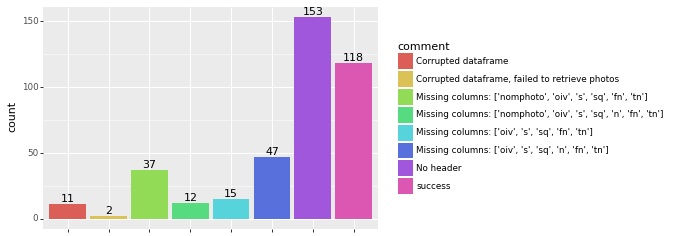

<ggplot: (191331056683)>

In [14]:
(
    ggplot(data=df_result)
    + aes(
        x="comment",
        # color="comment",
        fill="comment",
    )
    + geom_bar()
    + theme(
        figure_size=(10, 6),
        axis_text_x=element_blank(),
        # axis.text_x=element_blank()
    )
    + geom_text(aes(label=after_stat("count")), stat="count", nudge_y=0.125, va="bottom")
    + labs(x="")
)


##### Corrupted dataframes

In [15]:
df_corrupted = df_result[
    df_result.comment.isin(
        [
            "Corrupted dataframe",
            "Corrupted dataframe, failed to retrieve photos",
        ]
    )
].reset_index(drop=True)

df_corrupted.to_csv(
    os.path.join("..", "data_in", "corrupted_excels.csv"),
    index=False,
    sep=";",
)

df_corrupted


,file,sheet,outcome,comment,csv_file_name
0,Exp19DM10_saisie.xlsx,5dpi,False,"Corrupted dataframe, failed to retrieve photos",NaN
1,Exp19DM10_saisie.xlsx,7dpi,False,"Corrupted dataframe, failed to retrieve photos",NaN
2,Exp19PM12_inoc1_saisie.xlsx,1dpi data,False,Corrupted dataframe,NaN
3,Exp19PM12_inoc1_saisie.xlsx,2dpi data,False,Corrupted dataframe,NaN
4,Exp19PM12_inoc2_saisie.xlsx,1dpi data,False,Corrupted dataframe,NaN
5,Exp19PM12_inoc2_saisie.xlsx,2dpi data,False,Corrupted dataframe,NaN
6,Exp20PM04_inoc1_saisie.xlsx,3dpi data,False,Corrupted dataframe,NaN
7,Exp20PM04_inoc2_saisie.xlsx,3dpi data,False,Corrupted dataframe,NaN
8,Exp22DM01_inoc1_saisie.xlsx,Infos,False,Corrupted dataframe,NaN
9,Exp22DM02_inoc1_saisie.xlsx,Infos,False,Corrupted dataframe,NaN


### Merge dataframes

#### Retrieve CSVs

In [16]:
lcl_csv_files = [
    os.path.join(oidium_extracted_csvs_path, filename)
    for filename in df_result.csv_file_name.dropna().to_list()
]


Number of sheets successfully converted to CSVs

In [17]:
len(lcl_csv_files)

118

#### What columns are common all dataframes

In [18]:
common_columns = set(pd.read_csv(lcl_csv_files[0]).columns.to_list())
columns_occ = {}
for filepath in lcl_csv_files:
    cu_columns = pd.read_csv(filepath).columns.to_list()
    for c in cu_columns:
        if c in columns_occ:
            columns_occ[c] += 1
        else:
            columns_occ[c] = 1
    common_columns = common_columns.intersection(set(cu_columns))
common_columns = list(common_columns)
common_columns.sort()
common_columns

['colonne',
 'exp',
 'fn',
 'ligne',
 'n',
 'nomphoto',
 'n°tubestock',
 'oiv',
 'plaque',
 's',
 'sheet',
 'sq',
 'tn']

In [19]:
all_columns = sorted(list(columns_occ.keys()))

#### Merge

Merge all dataframes and:
- Remove rows with unwanted values
- Drop unwanted columns
- Change column names
- Set numerical columns
- Remove duplicates

In [20]:
df_final = pd.concat(
    [pd.read_csv(filepath)[common_columns] for filepath in lcl_csv_files]
)
df_final = (
    df_final[
        (~df_final.oiv.isin(["md", "dm", "na"]))
        & (~df_final.n.isin(["clair", "spo", "profildéjàobtenu"]))
    ]
    .drop(["n°tubestock","plaque"], axis=1)
    .dropna(subset=["oiv", "nomphoto"])
    .rename(
        columns={
            "exp": "experiment",
            "sheet": "sheet",
            "oiv": "oiv",
            "nomphoto": "image_name",
            "s": "sporulation",
            "fn": "surface_necrosee",
            "n": "necrose",
            "sq": "densité_sporulation",
            "tn": "taille_necrose",
        }
    )
    .sort_values(["image_name"])
    .assign(
        colonne=lambda x: x.colonne.astype(int),
        necrose=lambda x: x.necrose.astype('Int64'),
        oiv=lambda x: x.oiv.astype(int),
        sporulation=lambda x: x.sporulation.astype('Int64'),
        surface_necrosee=lambda x: x.surface_necrosee.astype('Int64'),
        densité_sporulation=lambda x: x.densité_sporulation.astype('Int64'),
        taille_necrose=lambda x: x.taille_necrose.astype('Int64'),
        oiv_cat=lambda x: x.oiv.astype(str),
    )
    .assign(necrose=lambda x: x.necrose.fillna(0))
    .drop_duplicates()
    .reset_index(drop=True)
)
df_final


,colonne,experiment,surface_necrosee,ligne,necrose,image_name,oiv,sporulation,sheet,densité_sporulation,taille_necrose,oiv_cat
0,1,Exp16DM01_saisie,<NA>,a,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
1,4,Exp16DM01_saisie,5,b,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
2,4,Exp16DM01_saisie,7,a,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
3,3,Exp16DM01_saisie,<NA>,c,0,Exp16DM01-Rep1-P1,3,1,fichier total,3,<NA>,3
4,3,Exp16DM01_saisie,<NA>,b,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
...,...,...,...,...,...,...,...,...,...,...,...,...
30933,3,Exp21DM14_inoc1_saisie,<NA>,a,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30934,3,Exp21DM14_inoc1_saisie,<NA>,b,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30935,3,Exp21DM14_inoc1_saisie,<NA>,c,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30936,4,Exp21DM14_inoc1_saisie,<NA>,b,1,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9


In [21]:
df_final.ligne.unique()

array(['a', 'b', 'c', nan], dtype=object)

In [22]:
df_final.necrose.unique()

<IntegerArray>
[0, 1, 7, 3, 5]
Length: 5, dtype: Int64

#### Overview

In [23]:
df_final.dtypes

colonne                 int32
experiment             object
surface_necrosee        Int64
ligne                  object
necrose                 Int64
image_name             object
oiv                     int32
sporulation             Int64
sheet                  object
densité_sporulation     Int64
taille_necrose          Int64
oiv_cat                object
dtype: object

##### Unique values

In [24]:
distincts_values = {}
for col in df_final.select_dtypes(exclude=object).columns:
    distincts_values[col] = list(df_final[col].unique())
distincts_values

{'colonne': [1, 4, 3, 2],
 'surface_necrosee': [<NA>, 5, 7, 9, 3, 1],
 'necrose': [0, 1, 7, 3, 5],
 'oiv': [3, 7, 5, 1, 9, 4, 2, 6],
 'sporulation': [1, 0, <NA>, 7],
 'densité_sporulation': [5, 7, 3, 1, 9, <NA>, 0, 2],
 'taille_necrose': [<NA>, 7, 5, 3, 9, 1]}

_Necrosis_ should be only 1 or 0
_Sporulation_ should be 1 or 0

Most sheets have incorrect values

In [25]:
df_final[(df_final.sporulation.isin([0, 1]) | df_final.necrose.isin([0, 1]))][
    ["experiment", "sheet"]
].drop_duplicates().reset_index(drop=True)


,experiment,sheet
0,Exp16DM01_saisie,fichier total
1,Exp16DM02_rep1_saisie,fichier total
2,Exp16DM02_rep2_saisie,fichier total
3,Exp16DM03_rep1_saisie,fichier total
4,Exp16DM03_rep2_saisie,fichier total
...,...,...
83,Exp21DM13_inoc1_saisie,3dpi
84,Exp21DM13_inoc2_saisie,6dpi
85,Exp21DM14_inoc1_saisie,4dpi
86,Exp21DM14_inoc1_saisie,8dpi


In [26]:
df_final = df_final[df_final.sporulation.isin([0,1]) & df_final.necrose.isin([0,1])]
df_final

,colonne,experiment,surface_necrosee,ligne,necrose,image_name,oiv,sporulation,sheet,densité_sporulation,taille_necrose,oiv_cat
0,1,Exp16DM01_saisie,<NA>,a,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
1,4,Exp16DM01_saisie,5,b,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
2,4,Exp16DM01_saisie,7,a,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
3,3,Exp16DM01_saisie,<NA>,c,0,Exp16DM01-Rep1-P1,3,1,fichier total,3,<NA>,3
4,3,Exp16DM01_saisie,<NA>,b,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
...,...,...,...,...,...,...,...,...,...,...,...,...
30933,3,Exp21DM14_inoc1_saisie,<NA>,a,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30934,3,Exp21DM14_inoc1_saisie,<NA>,b,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30935,3,Exp21DM14_inoc1_saisie,<NA>,c,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
30936,4,Exp21DM14_inoc1_saisie,<NA>,b,1,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9


##### Set balance

Are pair values an error ?

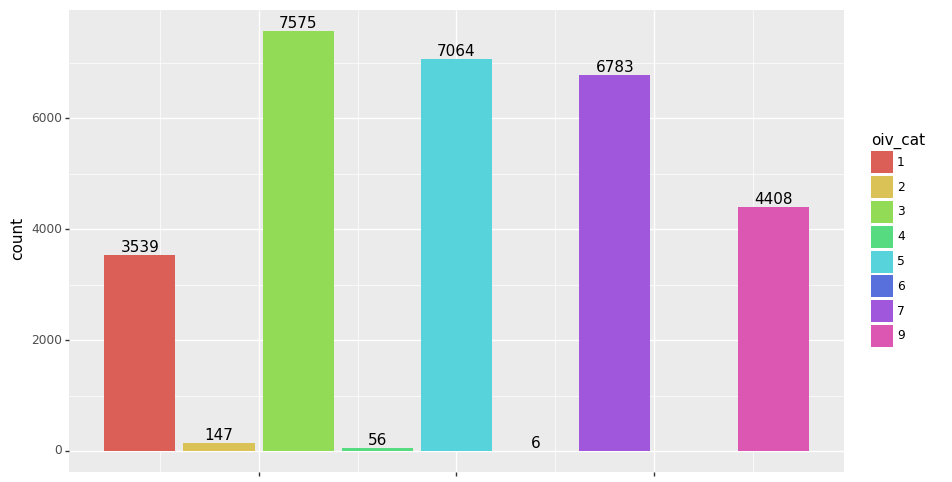

<ggplot: (191333366538)>

In [27]:
(
    ggplot(data=df_final)
    + aes(
        x="oiv",
        fill="oiv_cat",
    )
    + geom_bar()
    + theme(
        figure_size=(10, 6),
        axis_text_x=element_blank(),
        # axis.text_x=element_blank()
    )
    + geom_text(aes(label=after_stat("count")), stat="count", nudge_y=0.125, va="bottom")
    + labs(x="")
)


Keep odd OIVs

In [28]:
df_final = df_final[df_final.oiv.isin([1, 3, 5, 7, 9])]
(
    ggplot(data=df_final)
    + aes(
        x="oiv",
        fill="oiv_cat",
    )
    + geom_bar()
    + theme(
        figure_size=(10, 6),
        axis_text_x=element_blank(),)
    )
    + geom_text(aes(label=after_stat("count")), stat="count", nudge_y=0.125, va="bottom")
    + labs(x="")
)

IndentationError: unexpected indent (1340667090.py, line 13)

##### NAs

In [ ]:
nan_count = []
for c in df_final.columns:
    nan_count.append((c, df_final[c].isna().sum()))
nan_count

[('colonne', 0),
 ('experiment', 0),
 ('surface_necrosee', 21079),
 ('ligne', 1),
 ('necrose', 0),
 ('image_name', 0),
 ('oiv', 0),
 ('sporulation', 0),
 ('sheet', 0),
 ('densité_sporulation', 4355),
 ('taille_necrose', 21051),
 ('oiv_cat', 0)]

Remove NaN line row

In [ ]:
df_final = df_final.dropna(subset=["ligne"]).reset_index(drop=True)
df_final

,colonne,experiment,surface_necrosee,ligne,necrose,image_name,oiv,sporulation,sheet,densité_sporulation,taille_necrose,oiv_cat
0,1,Exp16DM01_saisie,<NA>,a,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
1,4,Exp16DM01_saisie,5,b,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
2,4,Exp16DM01_saisie,7,a,1,Exp16DM01-Rep1-P1,7,1,fichier total,7,7,7
3,3,Exp16DM01_saisie,<NA>,c,0,Exp16DM01-Rep1-P1,3,1,fichier total,3,<NA>,3
4,3,Exp16DM01_saisie,<NA>,b,0,Exp16DM01-Rep1-P1,3,1,fichier total,5,<NA>,3
...,...,...,...,...,...,...,...,...,...,...,...,...
29363,3,Exp21DM14_inoc1_saisie,<NA>,a,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
29364,3,Exp21DM14_inoc1_saisie,<NA>,b,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
29365,3,Exp21DM14_inoc1_saisie,<NA>,c,0,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9
29366,4,Exp21DM14_inoc1_saisie,<NA>,b,1,Exp21DM14-Inoc1-P5,9,0,4dpi,<NA>,<NA>,9


## Data overview

### Dataframe

In [ ]:
df_all = (
    df_final.sort_values(
        [
            "oiv",
            "experiment",
            "sheet",
        ]
    )
    .drop(["colonne", "ligne"], axis=1)
    .reset_index(drop=True)
)
df_all

,experiment,surface_necrosee,necrose,image_name,oiv,sporulation,sheet,densité_sporulation,taille_necrose,oiv_cat
0,Exp16DM01_saisie,<NA>,0,Exp16DM01-Rep1-P11,1,1,fichier total,1,<NA>,1
1,Exp16DM01_saisie,<NA>,0,Exp16DM01-Rep1-P11,1,1,fichier total,1,<NA>,1
2,Exp16DM01_saisie,<NA>,0,Exp16DM01-Rep1-P11,1,1,fichier total,1,<NA>,1
3,Exp16DM01_saisie,<NA>,0,Exp16DM01-Rep1-P11,1,1,fichier total,1,<NA>,1
4,Exp16DM01_saisie,<NA>,0,Exp16DM01-Rep1-P11,1,1,fichier total,1,<NA>,1
...,...,...,...,...,...,...,...,...,...,...
29363,Exp21DM14_inoc1_saisie,<NA>,0,Exp21DM14-Inoc1-P5,9,0,8dpi,<NA>,<NA>,9
29364,Exp21DM14_inoc1_saisie,<NA>,0,Exp21DM14-Inoc1-P5,9,0,8dpi,<NA>,<NA>,9
29365,Exp21DM14_inoc1_saisie,<NA>,1,Exp21DM14-Inoc1-P5,9,0,8dpi,<NA>,<NA>,9
29366,Exp21DM14_inoc1_saisie,<NA>,1,Exp21DM14-Inoc1-P5,9,0,8dpi,<NA>,<NA>,9


In [ ]:
df_nona_col = df_all[["oiv","necrose","sporulation", "oiv_cat"]].reset_index(drop=True)
df_nona_col

,oiv,necrose,sporulation,oiv_cat
0,1,0,1,1
1,1,0,1,1
2,1,0,1,1
3,1,0,1,1
4,1,0,1,1
...,...,...,...,...
29363,9,0,0,9
29364,9,0,0,9
29365,9,1,0,9
29366,9,1,0,9


In [ ]:
df_all.dtypes

experiment             object
surface_necrosee        Int64
necrose                 Int64
image_name             object
oiv                     int32
sporulation             Int64
sheet                  object
densité_sporulation     Int64
taille_necrose          Int64
oiv_cat                object
dtype: object

In [ ]:
df_num = df_all.select_dtypes(exclude=object)
df_num


,surface_necrosee,necrose,oiv,sporulation,densité_sporulation,taille_necrose
0,<NA>,0,1,1,1,<NA>
1,<NA>,0,1,1,1,<NA>
2,<NA>,0,1,1,1,<NA>
3,<NA>,0,1,1,1,<NA>
4,<NA>,0,1,1,1,<NA>
...,...,...,...,...,...,...
29363,<NA>,0,9,0,<NA>,<NA>
29364,<NA>,0,9,0,<NA>,<NA>
29365,<NA>,1,9,0,<NA>,<NA>
29366,<NA>,1,9,0,<NA>,<NA>


In [ ]:
df_num.dtypes

surface_necrosee       Int64
necrose                Int64
oiv                    int32
sporulation            Int64
densité_sporulation    Int64
taille_necrose         Int64
dtype: object

### Violin

In [ ]:
# df_melt = df_all.drop(["image_name", "oiv_cat"], axis=1).melt(
#     id_vars=["experiment", "sheet"],
#     var_name="value",
# )
# df_melt.columns = ["experiment", "sheet", "value", "dump"]
# df_melt = df_melt.drop(["dump"], axis=1)
# (
#     ggplot(data=df_melt)
#     + aes(
#         x="sheet",
#         y="value",
#     )
#     + geom_bar()
#     + theme(
#         figure_size=(16, 6),
#         # axis_text_x=element_blank(),
#         # axis.text_x=element_blank()
#     )
#     + geom_text(aes(label=after_stat("count")), stat="count", nudge_y=0.125, va="bottom")
#     + labs(x="")
# )


fig = make_subplots(rows=1, cols=len(df_num.columns))
for i, var in enumerate(df_num.columns):
    fig.add_trace(
        go.Violin(y=df_num[var], name=var),
        row=1,
        col=i + 1,
    )
fig.update_traces(points="all", jitter=0.3).update_layout(
    height=1000,
    width=1400,
)
fig

In [ ]:
df_all.shape

### Pairwise

In [ ]:
df_norm = df_all.select_dtypes(exclude=object)
# df_norm = df_norm / df_norm.max()
df_norm["oiv_cat"] = df_all.oiv_cat
df_norm["oiv"] = df_all.oiv
fig = px.scatter_matrix(
    df_norm, 
    color="oiv_cat",
    height=800,
    width=1000,
    dimensions=df_norm.select_dtypes(np.number).columns
)
fig.update_yaxes(tickangle=45, tickfont=dict(family='Rockwell', color='crimson', size=14))

# df_norm

### Heat map

In [ ]:
corr_matrix = df_all.corr()
corr_matrix

In [ ]:
px.imshow(
    corr_matrix,
    text_auto=True,
    height=800,
    width=1000,
)


In [ ]:
df_norm.dtypes

## PCA

#### All variables

In [ ]:
df_nona = df_all.dropna().reset_index(drop=True)

X = df_nona.drop(["oiv"], axis=1).select_dtypes(exclude=object).dropna()

column_names = X.columns.to_list()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca_data = PCA()
x_new = pca_data.fit_transform(X)

x_new.shape


In [ ]:
scatter_model(
    model=pca_data,
    df=df_nona.copy(),
    x_new=x_new,
    column_names=column_names,
    # loadings=np.transpose(pca_data.components_[0:2, :]),
    title="PCA with loadings",
)

In [ ]:
scatter_model(
    model=pca_data,
    df=df_nona.copy(),
    x_new=x_new,
    column_names=column_names,
    loadings=np.transpose(pca_data.components_[0:2, :]),
    title="PCA with loadings",
)

In [ ]:
plot_variance(
    df_ev=pd.DataFrame.from_dict(
        {
            "pc": [f"PC{i}" for i in range(len(pca_data.explained_variance_ratio_))],
            "exp_var_per": pca_data.explained_variance_ratio_ * 100,
        }
    )
)

In [ ]:
px.scatter_3d(
    x=x_new[:, 0] / x_new[:, 0].max(),
    y=x_new[:, 1] / x_new[:, 1].max(),
    z=x_new[:, 2] / x_new[:, 2].max(),
    color=df_nona.oiv_cat,
    height=800,
    width=1000,
    title="PCA 3D",
)    


#### Non NaN variables

In [ ]:
X = df_nona_col.drop(["oiv"], axis=1).select_dtypes(exclude=object).dropna()

column_names = X.columns.to_list()
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

pca_data = PCA()
x_new = pca_data.fit_transform(X)

scatter_model(
    model=pca_data,
    df=df_nona_col.copy(),
    x_new=x_new,
    column_names=column_names,
    loadings=np.transpose(pca_data.components_[0:2, :]),
    title="PCA with loadings",
)


In [ ]:
plot_variance(
    df_ev=pd.DataFrame.from_dict(
        {
            "pc": [f"PC{i}" for i in range(len(pca_data.explained_variance_ratio_))],
            "exp_var_per": pca_data.explained_variance_ratio_ * 100,
        }
    )
)

In [ ]:
df_3d = df_nona_col.assign(
    sporulation= lambda x: x.sporulation / x.sporulation.max(),
    oiv=lambda x: x.oiv / x.oiv.max(),
    necrose=lambda x: x.necrose / x.necrose.max(),
)

px.scatter_3d(
    data_frame=df_3d,
    x="oiv",
    y="sporulation",
    z="necrose",
    color="oiv_cat",
    height=800,
    width=1000,
    title="Data 3D",
)    


## PLs-DA

#### All variables

In [ ]:
df_nona = df_all.dropna().reset_index(drop=True)
X = df_nona.drop(["oiv"], axis=1).select_dtypes(exclude=object).dropna()

pls_data_all = PLSRegression(n_components=X.shape[1])
x_new = pls_data_all.fit(
    X, 
    df_nona.oiv,
).transform(X)

pls_data_all.score(X, df_nona.oiv)

In [ ]:
fig = px.scatter(
    x=pls_data_all.x_scores_[:, 0] / pls_data_all.x_scores_[:, 0].max(),
    y=pls_data_all.x_scores_[:, 1] / pls_data_all.x_scores_[:, 1].max(),
    color=df_nona.oiv_cat,
    height=800,
    width=1000,
)

fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=2, color="DarkSlateGrey"),
    ),
    selector=dict(mode="markers"),
)

fig


In [ ]:
[(target_value, target_name) for target_value, target_name in enumerate(df_nona.oiv.unique())]

#### Non NaN variables

In [ ]:
df_nona_col = df_all[["oiv","necrose","sporulation", "oiv_cat"]].reset_index(drop=True)
df_nona_col

In [ ]:
X = df_nona_col.drop(["oiv", "oiv_cat"], axis=1).select_dtypes(exclude=object)

pls_data = PLSRegression(n_components=X.shape[1])
x_new = pls_data.fit(
    X,
    df_nona_col.oiv,
).transform(X)

pls_data.score(X, df_nona_col.oiv)


In [ ]:
pls_data.x_scores_.shape

In [ ]:
fig = px.scatter(
    x=pls_data.x_scores_[:,0],
    y=pls_data.x_scores_[:,1],
    color=df_nona_col.oiv_cat,
    height=800,
    width=1000,
    opacity=0.5
)
fig.update_traces(
    marker=dict(
        size=12,
        line=dict(width=2, color="DarkSlateGrey"),
    ),
    selector=dict(mode="markers"),
)
fig